In [76]:
import pandas as pd
import numpy as np

df_with_python = pd.read_json("assistant_with_python.json")
df_without_python = pd.read_json("assistant_without_python.json")
df_o4_mini = pd.read_json("o4-mini-responses.json")


In [77]:
python_e_o = df_with_python.drop(['question', 'ai_response'], axis=1)
nopython_e_o = df_without_python.drop(['question', 'ai_response'], axis=1)
o4_mini_e_o = df_o4_mini.drop(["question", "ai_response"], axis=1)

In [78]:
print(python_e_o)
print(nopython_e_o)
print(o4_mini_e_o)

    expected_answer  actual_answer
0           1263.19    1263.190000
1         266670.41  266670.410000
2            708.91       3.140000
3             10.00      10.000000
4          10893.04   10893.043521
..              ...            ...
67        323492.92  323492.920000
68          1117.95    1117.950000
69             8.56       8.557000
70        180074.78  180075.000000
71         -2659.73   -3473.570000

[72 rows x 2 columns]
    expected_answer  actual_answer
0           1263.19        1260.09
1         266670.41      266629.00
2            708.91           3.14
3             10.00          10.10
4          10893.04        6267.60
..              ...            ...
67        323492.92      323330.00
68          1117.95        1116.08
69             8.56          10.50
70        180074.78      163971.00
71         -2659.73      -10321.80

[72 rows x 2 columns]
    expected_answer  actual_answer
0           1263.19        1263.07
1         266670.41      266712.00
2        

In [79]:
combined_df = pd.concat(
    [
        python_e_o.assign(model="gpt_4.1_with_python"),
        nopython_e_o.assign(model="gpt_4.1_without_python"),
        o4_mini_e_o.assign(model="o4_mini_without_python"),
    ],
    ignore_index=True,
)

In [80]:
combined_df['correct'] = (
    np.where(
        combined_df['expected_answer'] == 0,
        (combined_df['actual_answer'] == 0).astype(int),
        (abs(combined_df['expected_answer'] - combined_df['actual_answer']) <= 0.01 * abs(combined_df['expected_answer'])).astype(int)
    )
)

combined_df['percent_error'] = (
    abs((combined_df['actual_answer'] - combined_df['expected_answer']) / combined_df['expected_answer'])
) * 100

In [81]:
combined_df.groupby('model').describe()

expected_answer                                        \
                                 count          mean            std      min   
model                                                                          
gpt_4.1_with_python               72.0  58304.137778  105480.628573 -2659.73   
gpt_4.1_without_python            72.0  58304.137778  105480.628573 -2659.73   
o4_mini_without_python            72.0  58304.137778  105480.628573 -2659.73   

                                                              actual_answer  \
                           25%       50%       75%        max         count   
model                                                                         
gpt_4.1_with_python     629.53  1748.175  31615.91  323492.92          72.0   
gpt_4.1_without_python  629.53  1748.175  31615.91  323492.92          72.0   
o4_mini_without_python  629.53  1748.175  31615.91  323492.92          72.0   

                                      ... correct      percent_error  \
                                mean  ...     75%  max         count   
model                                 ...                              
gpt_4.1_with_python     55613.690633  ...     1.0  1.0          72.0   
gpt_4.1_without_python  53937.585972  ...     1.0  1.0          72.0   
o4_mini_without_python  55568.092778  ...     1.0  1.0          72.0   

                                                                        \
                             mean         std  min       25%       50%   
model                                                                    
gpt_4.1_with_python     38.735952  158.689593  0.0  0.000000  0.000016   
gpt_4.1_without_python  55.514057  116.077300  0.0  0.204636  2.142081   
o4_mini_without_python  20.887981   57.310880  0.0  0.009360  0.042978   

                                                
                              75%          max  
model                                           
gpt_4.1_with_python      0.035660  1285.043305  
gpt_4.1_without_python  53.537058   657.612991  
o4_mini_without_python   1.086816   261.956770  

[3 rows x 32 columns]

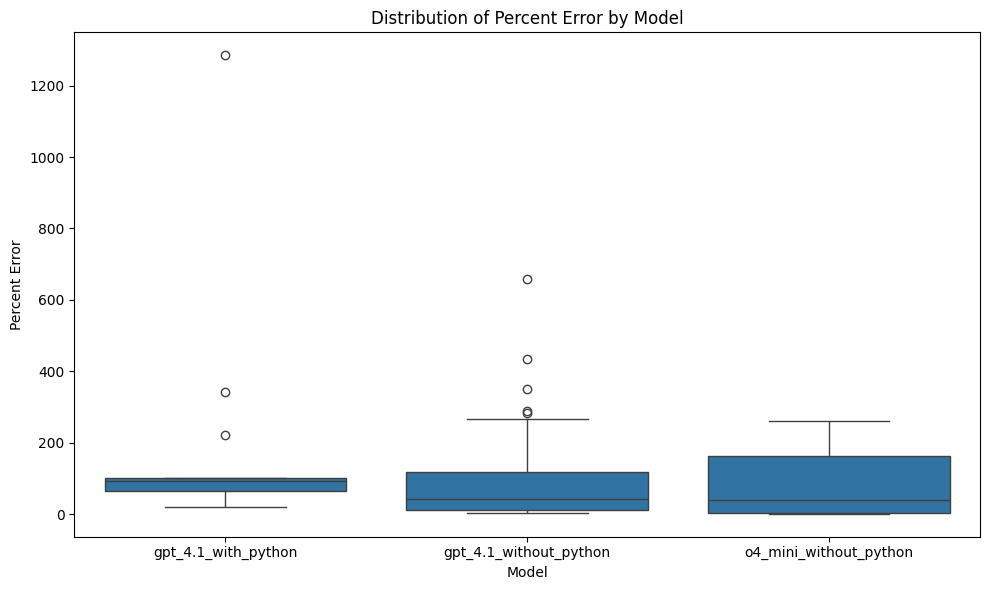

Interquartile Range (IQR) of percent_error by model:
 model
gpt_4.1_with_python        0.035660
gpt_4.1_without_python    53.332422
o4_mini_without_python     1.077456
Name: percent_error, dtype: float64

Standard Deviation (std) of percent_error by model:
 model
gpt_4.1_with_python       158.689593
gpt_4.1_without_python    116.077300
o4_mini_without_python     57.310880
Name: percent_error, dtype: float64


In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='model', y='percent_error', data=combined_df[combined_df['correct'] == 0])
plt.title('Distribution of Percent Error by Model')
plt.ylabel('Percent Error')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

iqr = combined_df.groupby('model')['percent_error'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
std = combined_df.groupby('model')['percent_error'].std()

print("Interquartile Range (IQR) of percent_error by model:\n", iqr)
print("\nStandard Deviation (std) of percent_error by model:\n", std)

In [83]:
accurate = combined_df[combined_df['correct'] == 1]
inaccurate = combined_df[combined_df["correct"] == 0]

accuracy = combined_df.groupby('model')['correct'].mean()

percent_error_accurate = accurate.groupby('model')['percent_error'].mean()
percent_error_inaccurate = inaccurate.groupby('model')['percent_error'].mean()

summary_table = pd.DataFrame({
    'Accuracy': accuracy,
    'Percent Error (Correct)': percent_error_accurate,
    'Percent Error (Incorrect)': percent_error_inaccurate
})

print(summary_table)

                        Accuracy  Percent Error (Correct)  \
model                                                       
gpt_4.1_with_python     0.777778                 0.004380   
gpt_4.1_without_python  0.458333                 0.255949   
o4_mini_without_python  0.736111                 0.134875   

                        Percent Error (Incorrect)  
model                                              
gpt_4.1_with_python                    174.296455  
gpt_4.1_without_python                 102.270918  
o4_mini_without_python                  78.778225  


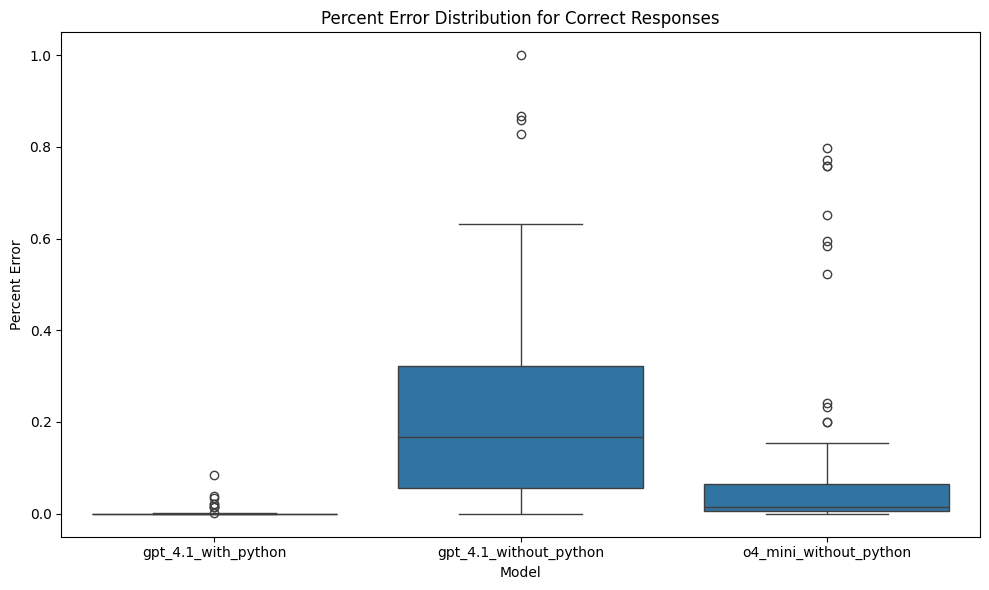

In [84]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="model", y="percent_error", data=combined_df[combined_df['correct'] == 1])

plt.title("Percent Error Distribution for Correct Responses")
plt.ylabel("Percent Error")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

In [85]:
num_questions = 0

prev_questions = set()
for _, response in df_with_python.iterrows():
    if response['question'] in prev_questions:
        break;
    else:
        prev_questions.add(response['question'])
    num_questions += 1

num_repeats = int(len(df_with_python) / num_questions)

print(num_questions, num_repeats)

18 4


Model: gpt_4.1_with_python
Consistent answers for 10 out of 18 questions
Medium error: 0.00014982461488637473
Model: gpt_4.1_without_python
Consistent answers for 0 out of 18 questions
Medium error: 5.576443593264438
Model: o4_mini_without_python
Consistent answers for 0 out of 18 questions
Medium error: 0.1184867750466864


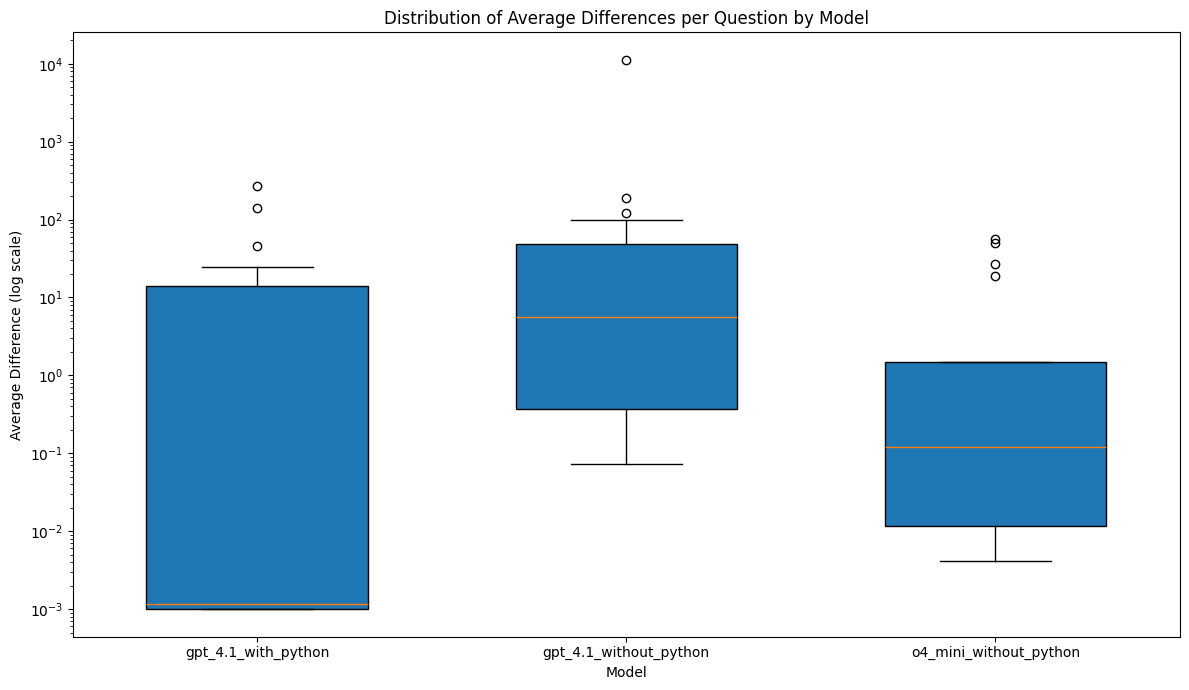

In [86]:
question_indices = [[q + 18 * r for r in range(num_repeats)] for q in range(num_questions)]

consistency_summary = {}

for model in combined_df['model'].unique():
    model_df = combined_df[combined_df['model'] == model].reset_index(drop=True)
    question_consistency = []
    avg_diffs = []
    for idx_set in question_indices:
        answers = model_df.loc[idx_set, 'actual_answer'].values
        consistent = np.allclose(answers, answers[0], rtol=1e-5, atol=1e-8)
        # Calculate percent difference relative to the first answer
        percent_diffs = np.abs((answers - answers[0]) / answers[0]) * 100
        avg_percent_diff = np.mean(percent_diffs)
        question_consistency.append(consistent)
        avg_diffs.append(avg_percent_diff)
    consistency_summary[model] = {
        'num_consistent': sum(question_consistency),
        'num_questions': num_questions,
        'consistency_per_question': question_consistency,
        'avg_difference_per_question': avg_diffs,
        'overall_avg_difference': np.mean(avg_diffs)
    }

for model, result in consistency_summary.items():
    print(f"Model: {model}")
    print(f"Consistent answers for {result['num_consistent']} out of {result['num_questions']} questions")

    print(f"Medium error: {np.median(result['avg_difference_per_question'])}")

epsilon = 1e-3

plt.figure(figsize=(12, 7))
for model, result in consistency_summary.items():
    plt.boxplot(
        np.array(result["avg_difference_per_question"]) + epsilon,
        positions=[list(consistency_summary.keys()).index(model)],
        widths=0.6,
        patch_artist=True,
    )
plt.xticks(range(len(consistency_summary)), list(consistency_summary.keys()))
plt.title("Distribution of Average Differences per Question by Model")
plt.ylabel("Average Difference (log scale)")
plt.xlabel("Model")
plt.yscale("log")
plt.tight_layout()
plt.show()